In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# pymc imports
import pymc as pm
import arviz as az

In [ ]:
# check pymc, arviz version
print(f"pyMC version\t{pm.__version__}\narviz version\t{az.__version__}")

pyMC version	5.7.2
arviz version	0.15.1


# Basics

- Build model: context or environment to define variables and distributions (`with pm.Model() as ModelName:`)

- variables defined within the context manager can be interrogated outside the contenxt.

- you can do things like: find the `logp` of a particular realization (smaller for less likely arguments) and `draw` random numbers.

In [ ]:
# instantiate a simple model with a standard normally distributed variable
with pm.Model() as SimpleModel:
    mu = pm.Normal("mu", mu=1.0, sigma=1.0)

In [ ]:
# stored as a special tensor variable
type(mu)

pytensor.tensor.var.TensorVariable

In [ ]:
# all distributions have a logp (and optionally draw) functions associated with them
print(f" logp(0.8) = {pm.logp(mu, 0.8).eval():.4f}\n logp(0.5) = {pm.logp(mu, 5).eval():.4f}")

 logp(0.8) = -0.9389
 logp(0.5) = -8.9189


In [ ]:
# regular numpy array
print(pm.draw(mu, 5))

[ 0.54898246 -0.41939603  2.99898407  2.7365104   1.62730902]


# Examples

Let us pick a few examples, some of which we have previously seen in class.

## 1. Cheating Lab

Consider  the cheating lab from class. Here's a quick summary

We asked $N = 100$ students whether they cheated on an exam, and $X = 35$ answered "Yes". The goal was to estimate the prevalance of cheating $p_\text{true}$.

However, to anonymize the answers, we added noise to the responses. Thus the observations were skewed. The likelihood function followed a binomial distritibution

$$\pi(X | p_\text{true}) = {}^{N}C_{X} \, p_\text{skew}^X (1-p_\text{skew})^{N - X}$$

where $p_\text{skew}  = 0.5 p_\text{true} + 0.25$. The prior is a uniform distribution $\pi(p_\text{true})$ is $U[0, 1]$.

Let us use pyMC to sample the posterior using MCMC.

In [ ]:
# describe the observed data
N = 100
X = 35

- variables and functions defined outside the context are not automatically added/tracked by the model

- any "deterministic" variables which may be functions of random variables are anonymous, unless you use the `pm.Deterministic` construct to track them.

In [ ]:
with pm.Model() as cheating:
    ptrue  = pm.Uniform("ptrue", lower=0, upper=1)                 # prior
    pskew  = pm.Deterministic("p_skewed", 0.5*ptrue + 0.25)        # can also use pskew = 0.5*ptrue + 0.25, but then variable pskew is not tracked
#    pskew  = 0.5*ptrue + 0.25
    like   = pm.Binomial("number_cheaters", N, pskew, observed=X)  # likelihood
    method = pm.Metropolis()                                       # mcmc sampler

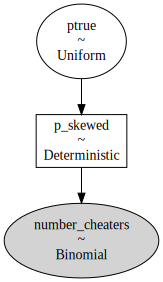

In [ ]:
# visualize the model graphically
pm.model_to_graphviz(cheating)

We can crack open the context manger whenever we want. Now that we have defined the model, let us do some sampling.

In [ ]:
with cheating:
    trace  = pm.sample(draws=2000, step=method, cores=4, chains=4)

- By default it performs "tuning" or burn-in for 1000 steps, and discards those samples.

- Since running multiple chains is embarrasingly parallel, we can ask it to use multiple cores

- Here we are running 4 independent chains. The number of chains and cores do not have to match, but it helps if they are multiples of each other.

- The output is collected in a special data structure that can use the arviz library

In [ ]:
# in notebooks you can click and open different sub-containers
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

Alternatively you can interrogate the elements programmatically.

In [ ]:
# how many chains were sampled
trace.posterior.dims

Frozen({'chain': 4, 'draw': 2000})

In [ ]:
# the samples: 4 chains with 1000 samples each
trace.posterior["ptrue"].shape

(4, 2000)

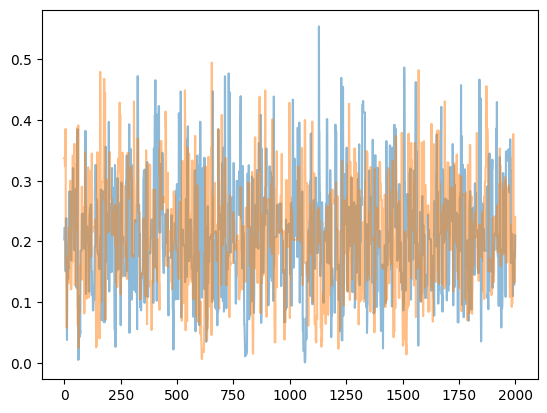

In [ ]:
# You can select a particular chain, and visualize its trace
#trace.posterior["ptrue"].sel(chain=1).shape

plt.plot(trace.posterior["ptrue"].sel(chain=1), alpha=0.5)
plt.plot(trace.posterior["ptrue"].sel(chain=3), alpha=0.5)

Or you can use powerful tools from the arviz library to interrogate the output.

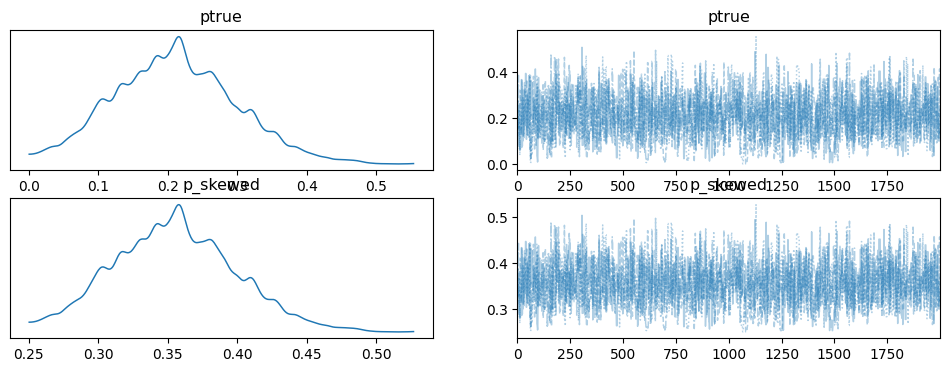

In [ ]:
# traceplots
az.plot_trace(trace, combined=True); # combine the 4 chains; otherwise independent chains

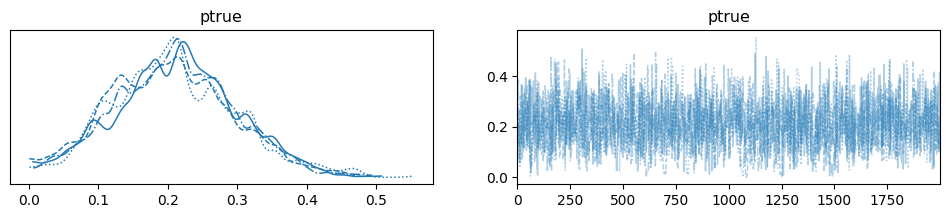

In [ ]:
# retain identities of the 4 chains, and only produce traceplots of selected variables
az.plot_trace(trace, var_names="ptrue");

In [ ]:
# summarize the data; note provides rhat measure
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ptrue,0.210,0.088,0.050,0.381,0.002,0.002,1363.0,1123.0,1.0
p_skewed,0.355,0.044,0.275,0.440,0.001,0.001,1363.0,1123.0,1.0


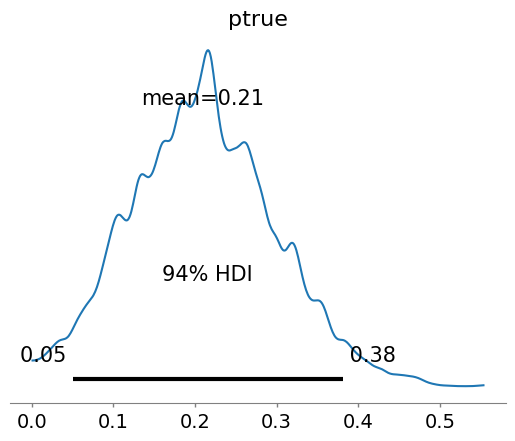

In [ ]:
# summarize the posterior (#HDI = high density interval)
az.plot_posterior(trace, var_names="ptrue");

If you perform an expensive simulation, you might want to save your results.

To [save](https://discourse.pymc.io/t/how-to-save-my-trace-in-the-system/7222) the inference data object to a file in [netCDF](https://en.wikipedia.org/wiki/NetCDF) format, you use:

In [ ]:
with cheating:
    trace.to_netcdf("output.nc")


# to read it later in a different session
trace = az.from_netcdf("output.nc")

## 2. Parameter estimation for stretched exponential

The [stretched exponential function](https://en.wikipedia.org/wiki/Stretched_exponential_function),
$$S(t) = \alpha \exp\left(-\dfrac{t}{\tau}\right)^{\beta},$$
is widely used in materials science, statistics, spectroscopy, social sciences etc. See introduction in [Elton's monograph](https://arxiv.org/pdf/1808.00881.pdf) for history and additional context. It is often used as a phenomenological function to fit data over many orders of magnitude.

The parameter $0 < \beta \leq 2$ is called the stretching exponential; $\beta = 1$ and $\beta = 2$ are special cases that correspond to the exponential and Gaussian functions. Furthermore, the timescale $\tau > 0$, and $t \in [0, \infty]$.

### Goal

We are given experimental (synthetic) data, which is contaminated with noise. We hope to "fit" a stretched exponential function to it. That is, we want to infer the parameters $\theta = [\alpha, \tau, \beta]$ from the data. We could pose this as an optimization problem, and find the best-fit parameters.

### Synthetic data

We generate synthetic data $\{t_i, d_i\}$ by assuming a particular $\theta$, evaluating the stretched exponential function, and adding some white noise (zero mean, variance $\sigma^2$). Thus,
$$d_i = S(t_i) + \mathcal{N}(0,\sigma^2), \quad i = 1, 2,\cdots, n$$




In [ ]:
# stretched exponentia function
def sef(t, alpha, tau, beta):
    return alpha*np.exp(-(t/tau)**beta)

In [ ]:
# contaminate signal with noise
np.random.seed(1234)
noise_data = 0.01
theta_data = np.array([0.5, 1.0, 0.7])   # SEF parameters (alpha, tau, beta)

tdata = np.logspace(-1, 2, 50)
Sdata = sef(tdata, theta_data[0], theta_data[1], theta_data[2]) + noise_data * np.random.normal(size=len(tdata))

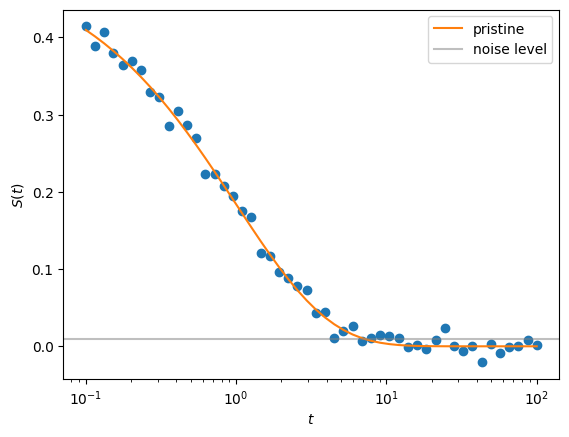

In [ ]:
plt.plot(tdata, Sdata, 'o')
plt.plot(tdata, sef(tdata, theta_data[0], theta_data[1], theta_data[2]), label='pristine')
plt.xscale('log')
plt.axhline(y=noise_data, c='gray', alpha=0.5, label='noise level')
plt.xlabel(r'$t$')
plt.ylabel(r'$S(t)$');
plt.legend()

### Sampling Using pyMC

Now we are construct a statistical model to infer not only the three parameters of the SEF, but also the noise $\sigma^2$.

**Priors**

In Bayesian inference, we have to specify some prior guesses for these parameters. Since $\sigma^2$ and $\tau$ are positive, we can use [half-normal distributions](https://en.wikipedia.org/wiki/Half-normal_distribution) to characterize them. We know $\beta \in [0, 2]$; we can set its prior as a uniform distribution. Finally, we can take $\alpha$ to be a normally distributed quantity.

\begin{align}
\sigma & \sim \text{HN}(\sigma_\sigma = 1)\\
\tau & \sim \text{HN}(\sigma_\tau = 20)\\
\beta & \sim \text{U}[0, 2]\\
\alpha & \sim \mathcal{N}(0, \sigma_\alpha = 5)
\end{align}

In [ ]:
with pm.Model() as model:
    sig   = pm.HalfNormal('sig', sigma=1)
    tau   = pm.HalfNormal('tau', sigma=20)
    beta  = pm.Uniform('beta', 0, 2)
    alpha = pm.Normal('alpha', mu=0, sigma=5)

The error model stems from the relation $d_i = S(t_i, \theta) +  e_i$. That is the observed data (`Sdata`) is normally distributed around the SEF with parameters = `theta`.
$$d \sim \mathcal{N}(S(t_i, \theta), \sigma^2)$$
This forms the core of our statistical model.

In [ ]:
with model:
    S_pred = pm.Normal('S_pred', mu=sef(tdata, alpha, tau, beta), sigma=sig, observed=Sdata)  # bringing it all together
    idata  = pm.sample()

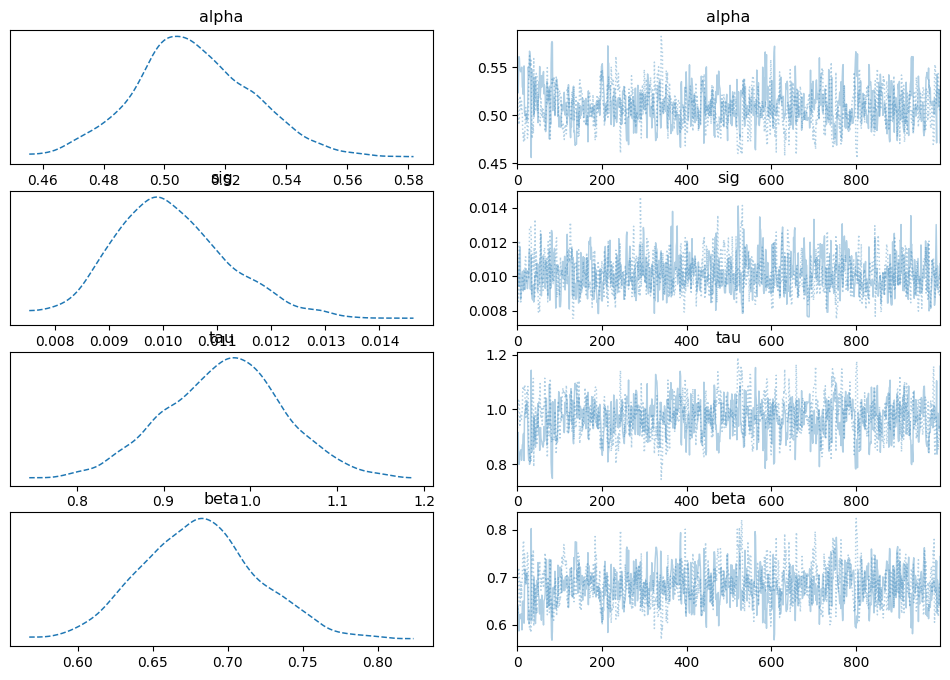

In [ ]:
az.plot_trace(idata, combined=True);

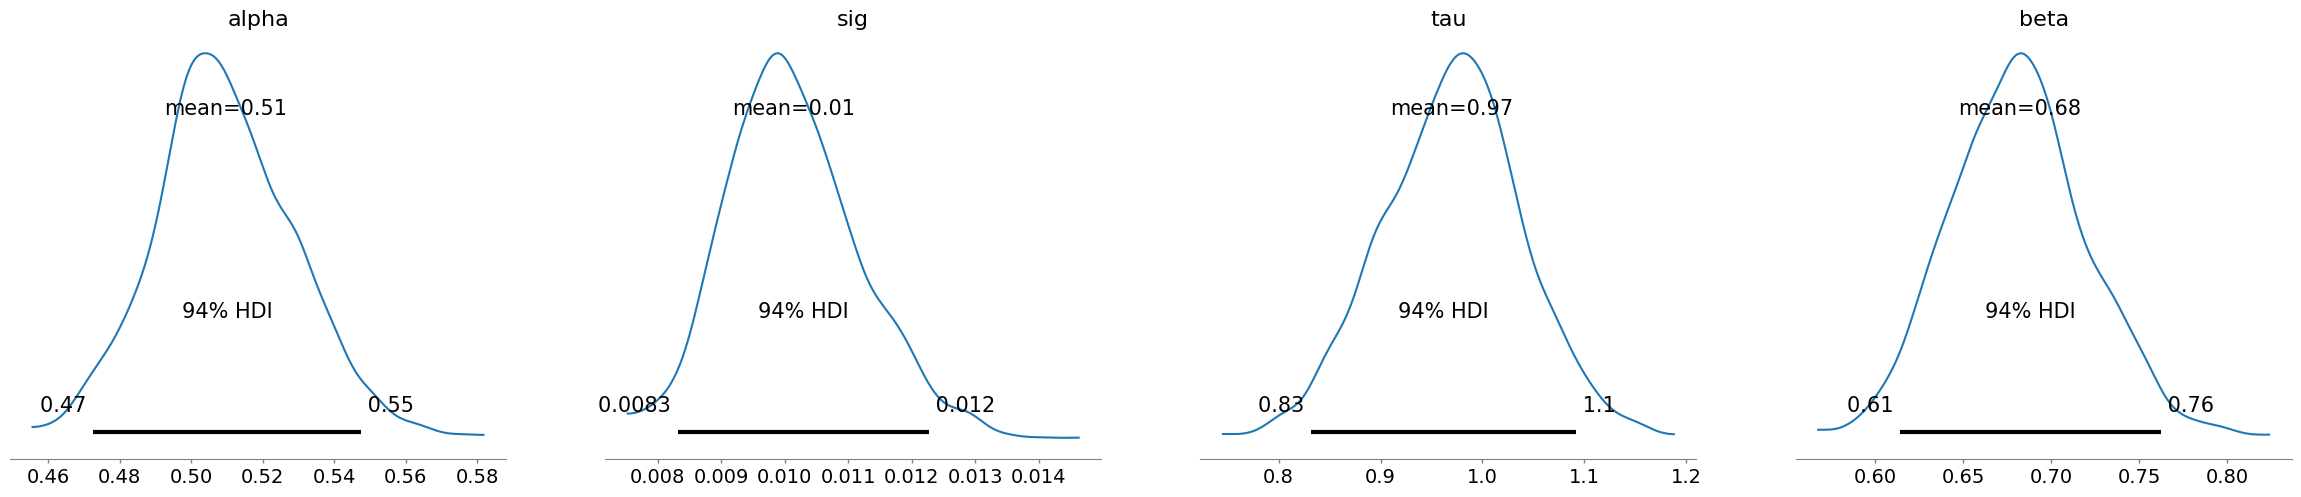

In [ ]:
az.plot_posterior(idata);

<Axes: xlabel='tau', ylabel='beta'>

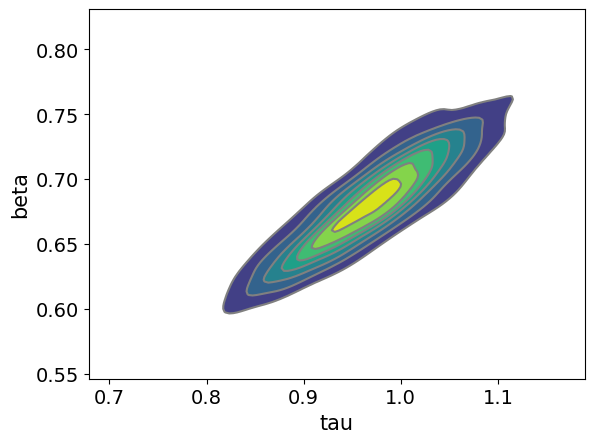

In [ ]:
# correlations between different parameters
az.plot_pair(idata, var_names=['tau', 'beta'], kind='kde')

### Posterior predictive for Calibration Check

Goodness of fit is a calibration check. Samples from posterior should look like the data.

pyMC can readily generate samples from the posterior distribution

$$ \text{Pr}(y | \text{data}) = \int \text{Pr}(y | \theta) \, \text{Pr}(\theta | \text{data})\, d\theta$$

where $\text{Pr}(\theta | \text{data})$ is the posterior distribution.

In [ ]:
ppc = pm.sample_posterior_predictive(idata, model=model)

<Axes: xlabel='S_pred / S_pred'>

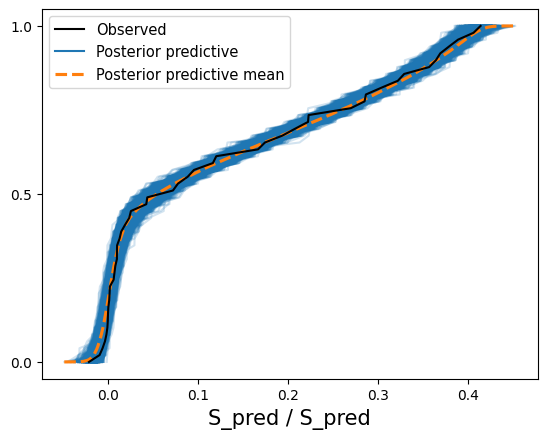

In [ ]:
# CDF of S values should resemble that of the data
az.plot_ppc(ppc, kind='cumulative')

The posterior predictive data matches the structure of the inference object. Since the original data had 4 chains with 1000 draws, the same structure is created.

In [ ]:
# select one of the chains to do some uncertainty analysis plotting
ppc_ch1 = ppc.posterior_predictive.S_pred.sel(chain=1)
ppc_ch1.shape

(1000, 50)

We can produce uncertainty estimates and error bands for the predictions.

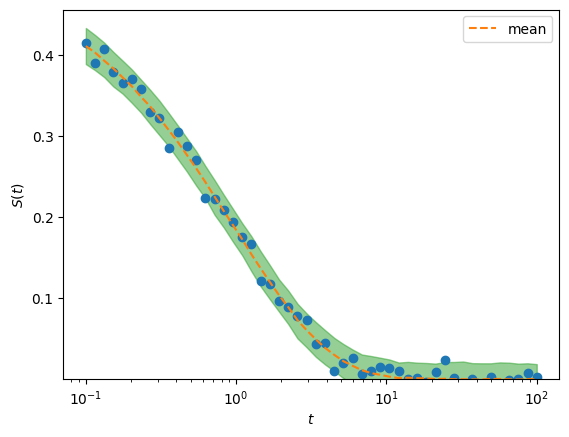

In [ ]:
crit_l = np.percentile(ppc_ch1 ,q=2.5,axis=0)  # grab lower 2.5% quantiles
crit_u = np.percentile(ppc_ch1 ,q=97.5,axis=0)  # grab Upper 97.5% quantiles
mean_spp = np.mean(ppc_ch1 , axis=0) # mean

plt.plot(tdata, Sdata, 'o')

plt.plot(tdata, mean_spp, '--', label='mean')
plt.fill_between(tdata, crit_l, crit_u, alpha=0.5, color='C2')
plt.xscale('log')
plt.xlabel(r'$t$')
plt.ylabel(r'$S(t)$')
plt.ylim(1e-5, None)
plt.legend()

### 3. Sampling from Custom Distributions

So far, we used pyMC to sample the posterior distribution based on some observed data

Suppose we do not have any observations.

We can still use pyMC to sample from arbitrary target distributions.

We simply specify the `logp` of the target distribution. The log probability need not be normalized. So any prefactors can be ignored.

We shall consider a few simple examples, first, before reconsidering the "three peaks" example from class.

Let us start with the normal distribution with mean $\mu$ and variance $\sigma^2$.

In this case, only the argument of the exponential term has to be retained.

$$\log \mathcal{N}(x, \mu, \sigma^2) = \text{constant} - \frac{(x - \mu)^2}{\sigma^2}$$

In [ ]:
from pytensor.tensor import TensorVariable

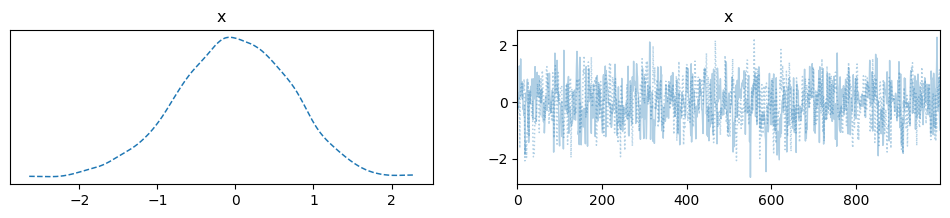

In [ ]:
def logp_normal(x: TensorVariable, mu : TensorVariable, sigma2 : TensorVariable) -> TensorVariable:
    return -(x - mu)**2/sigma2

with pm.Model():
    pm.CustomDist('x', 0.0, 1.0, logp=logp_normal)
    idata = pm.sample(1000)

az.plot_trace(idata, combined=True);

Now consider a truncated normal distribution, where $x > 0$. We can encode such finite boundaries using the `switch` function.

Note that `log(1) = 0` and `log(0) = -inf`.  The latter marks forbidden regions of the domain.

In [ ]:
# constraint of x>0 and unit normal
def logp_truncnormal(value: TensorVariable, mu : TensorVariable, sigma2 : TensorVariable) -> TensorVariable:
    constraint = value > 0.
    return -(value - mu)**2/sigma2 + pm.math.log(pm.math.switch(constraint, 1, 0))

with pm.Model():
    pm.CustomDist('x', 1.0, 1.0, logp=logp_truncnormal)
    # idata = pm.sample(draws=1000)  # HMC has trouble with sharp boundary near high density region
    idata = pm.sample(draws=1000, step=pm.Slice(), initvals={"x": 1})  # can specify method and initial value

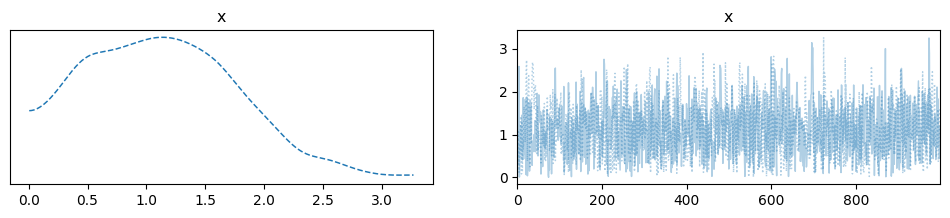

In [ ]:
az.plot_trace(idata, combined=True);

### Three Peaks Example

Now consider the PDF with three peaks:

$$\begin{align*}
\pi(x,y) \sim & \exp\left(-\frac{1}{10} (x^2 + y^2)\right) + \\ & \frac{1}{2} \exp\left(-\frac{1}{20} ((x-20.)^2 +(y-20.)^2)\right) + \\ & \exp\left(-\frac{1}{200} ((x-40.)^2 + (y-40.)^2)\right)\\
\end{align*}$$


In [ ]:
# odlder function
def fxy(x,y):
    """Definition of Function"""
    f  = np.exp(-1/10. * (x**2 + y**2))
    f += 0.5 * np.exp(-1/20. * ((x-20.)**2 + (y-20.)**2))
    f += np.exp(-1/200. * ((x-40.)**2 + (y-40.)**2))

    return f

# interface it
def logp_ridge_peak(value: TensorVariable) -> TensorVariable:
    f = fxy(value[0], value[1])
    return pm.math.log(f)

In [ ]:
with pm.Model():
    pm.CustomDist('x', logp=logp_ridge_peak, shape=(2,))   # shape tells it that we have 2D distribution
    idata = pm.sample(draws=10000, tune=1000, step=pm.Slice())

In [ ]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x[0],37.299,13.343,14.095,64.282,1.482,1.052,160.0,29.0,1.01
x[1],37.152,13.377,13.811,64.263,1.507,1.069,164.0,28.0,1.01


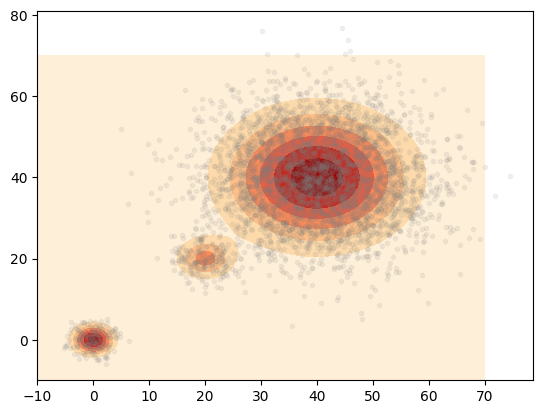

In [ ]:
from matplotlib import cm
import matplotlib.pyplot as plt

for i in range(len(idata.posterior.x.chain)):
    recz = np.array(idata.posterior.x[i])
    plt.plot(recz[::5, 0],recz[::5, 1], '.', c='gray', alpha=0.1)

x = np.linspace(-10,70,100)
X, Y = np.meshgrid(x,x)
Z = fxy(X,Y)
Z = Z.reshape(X.shape)

plt.contourf(X,Y,Z, cmap=cm.OrRd)

2